In [ ]:
# Gerekli kütüphaneleri yükle
!pip install GEOparse openpyxl pandas scikit-learn numpy matplotlib

import GEOparse
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import openpyxl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer


In [ ]:
# GEO veri setlerini yükle
gse25066 = GEOparse.get_GEO("GSE25066")
gse3494 = GEOparse.get_GEO("GSE3494")

21-May-2024 10:06:55 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
21-May-2024 10:06:55 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25066/soft/GSE25066_family.soft.gz to ./GSE25066_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25066/soft/GSE25066_family.soft.gz to ./GSE25066_family.soft.gz
100%|██████████| 101M/101M [00:16<00:00, 6.51MB/s]
21-May-2024 10:07:13 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
21-May-2024 10:07:13 DEBUG downloader - Moving /tmp/tmpcafanb3z to /content/GSE25066_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpcafanb3z to /content/GSE25066_family.soft.gz
21-May-2024 10:07:13 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25066/soft/GSE25066_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE2506

In [ ]:
# ExpressionSet nesnelerinden ifade matrislerini çıkar
exprs1 = gse25066.pivot_samples('VALUE')
exprs2 = gse3494.pivot_samples('VALUE')

In [ ]:
# Gen sayısı ve örnek sayısını ekrana yazdırma
print(f"GSE25066 veri setindeki gen sayısı: {exprs1.shape[0]}")
print(f"GSE25066 veri setindeki örnek sayısı: {exprs1.shape[1]}")
print(f"GSE3494 veri setindeki gen sayısı: {exprs2.shape[0]}")
print(f"GSE3494 veri setindeki örnek sayısı: {exprs2.shape[1]}")

GSE25066 veri setindeki gen sayısı: 22283
GSE25066 veri setindeki örnek sayısı: 508
GSE3494 veri setindeki gen sayısı: 44760
GSE3494 veri setindeki örnek sayısı: 502


In [ ]:
# Genefilter ile filtreleme
def filter_genes(exprs, var_cutoff=0.80):
    selector = VarianceThreshold(threshold=(np.percentile(np.var(exprs, axis=1), 80)))
    filtered_exprs = selector.fit_transform(exprs.T).T
    return pd.DataFrame(filtered_exprs, index=exprs.index[selector.get_support(indices=True)], columns=exprs.columns)

filtered_exprs1 = filter_genes(exprs1)
filtered_exprs2 = filter_genes(exprs2)

In [ ]:
# Ortak genleri bul ve her iki veri seti için verileri birleştir
common_genes = filtered_exprs1.index.intersection(filtered_exprs2.index)
combined_exprs = pd.concat([filtered_exprs1.loc[common_genes], filtered_exprs2.loc[common_genes]], axis=1)

In [ ]:
# Excel dosyasına yazma
combined_exprs.to_excel("combined_exprs.xlsx", index=False)

In [ ]:
# Birleştirilmiş veri setindeki gen sayısı ve örnek sayısını ekrana yazdırma
print(f"Birleştirilmiş veri setindeki gen sayısı: {combined_exprs.shape[0]}")
print(f"Birleştirilmiş veri setindeki örnek sayısı: {combined_exprs.shape[1]}")

Birleştirilmiş veri setindeki gen sayısı: 3056
Birleştirilmiş veri setindeki örnek sayısı: 1010


In [ ]:
# Sınıf etiketlerini oluştur
labels = np.array(['Class1'] * filtered_exprs1.shape[1] + ['Class2'] * filtered_exprs2.shape[1])
combined_exprs_transposed = combined_exprs.T
combined_exprs_transposed['label'] = labels

In [ ]:
# Veri setini eğitim ve test seti olarak ayır
X = combined_exprs_transposed.drop('label', axis=1)
y = combined_exprs_transposed['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

## Özellik Seçimi

In [ ]:
# Özellik seçimi - Tek değişkenli istatistikler kullanarak en iyi 50 geni seç
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)


selector = SelectKBest(f_classif, k=50)
X_train_selected = selector.fit_transform(X_train_imputed, y_train)
X_test_selected = selector.transform(X_test_imputed)

In [ ]:
# Seçilen genlerin isimlerini al
selected_genes = X.columns[selector.get_support(indices=True)]
print("Seçilen genler:", selected_genes)

Seçilen genler: Index(['201123_s_at', '202086_at', '202089_s_at', '202388_at', '202648_at',
       '202917_s_at', '203021_at', '203535_at', '203936_s_at', '204533_at',
       '204563_at', '204580_at', '204959_at', '205347_s_at', '205483_s_at',
       '205922_at', '206962_x_at', '207076_s_at', '208894_at', '209116_x_at',
       '209604_s_at', '209875_s_at', '209969_s_at', '210735_s_at',
       '210982_s_at', '211000_s_at', '211372_s_at', '211565_at', '211699_x_at',
       '211991_s_at', '212003_at', '212587_s_at', '212588_at', '213539_at',
       '213975_s_at', '214290_s_at', '214414_x_at', '215891_s_at',
       '216207_x_at', '216913_s_at', '217517_x_at', '218211_s_at',
       'AFFX-HUMISGF3A/M97935_5_at', 'AFFX-HUMRGE/M10098_3_at',
       'AFFX-HUMRGE/M10098_5_at', 'AFFX-HUMRGE/M10098_M_at',
       'AFFX-r2-Hs18SrRNA-3_s_at', 'AFFX-r2-Hs18SrRNA-5_at',
       'AFFX-r2-Hs18SrRNA-M_x_at', 'AFFX-r2-Hs28SrRNA-M_at'],
      dtype='object', name='ID_REF')


In [ ]:
# Seçilen genlerin isimlerini içeren DataFrame oluşturma
selected_genes_df = pd.DataFrame({'Seçilen Genler': selected_genes})

# Tabloyu ekrana yazdırma
print(selected_genes_df)


                Seçilen Genler
0                  201123_s_at
1                    202086_at
2                  202089_s_at
3                    202388_at
4                    202648_at
5                  202917_s_at
6                    203021_at
7                    203535_at
8                  203936_s_at
9                    204533_at
10                   204563_at
11                   204580_at
12                   204959_at
13                 205347_s_at
14                 205483_s_at
15                   205922_at
16                 206962_x_at
17                 207076_s_at
18                   208894_at
19                 209116_x_at
20                 209604_s_at
21                 209875_s_at
22                 209969_s_at
23                 210735_s_at
24                 210982_s_at
25                 211000_s_at
26                 211372_s_at
27                   211565_at
28                 211699_x_at
29                 211991_s_at
30                   212003_at
31      

## Sınıflandırma

Karar Ağacı

In [ ]:
# Sınıflandırma - Karar Ağacı modeli
model = DecisionTreeClassifier()
model.fit(X_train_selected, y_train)

DecisionTreeClassifier()

In [ ]:
# Model özeti
print(model)

DecisionTreeClassifier()


In [ ]:
# Test veri seti üzerinden tahmin yap ve doğruluk hesapla
y_pred = model.predict(X_test_selected)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk: {accuracy * 100:.2f}%")

Doğruluk: 99.50%


In [ ]:
# Karışıklık matrisi
print(conf_matrix)

[[ 96   1]
 [  0 105]]


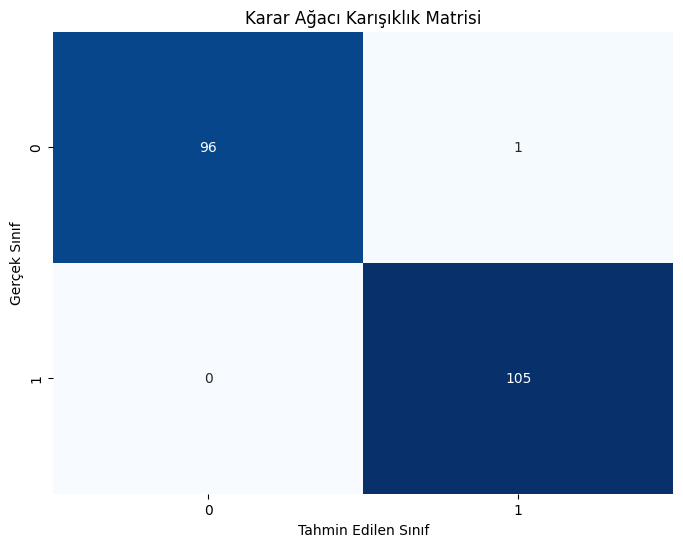

In [ ]:
import seaborn as sns

# Görselleştirme için karışıklık matrisi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karar Ağacı Karışıklık Matrisi')
plt.show()

Random Forests

In [ ]:
# Random Forests
rf_model = RandomForestClassifier()
rf_model.fit(X_train_selected, y_train)
rf_y_pred = rf_model.predict(X_test_selected)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Doğruluk: {rf_accuracy * 100:.2f}%")
print(rf_conf_matrix)

Random Forest Doğruluk: 100.00%
[[ 97   0]
 [  0 105]]


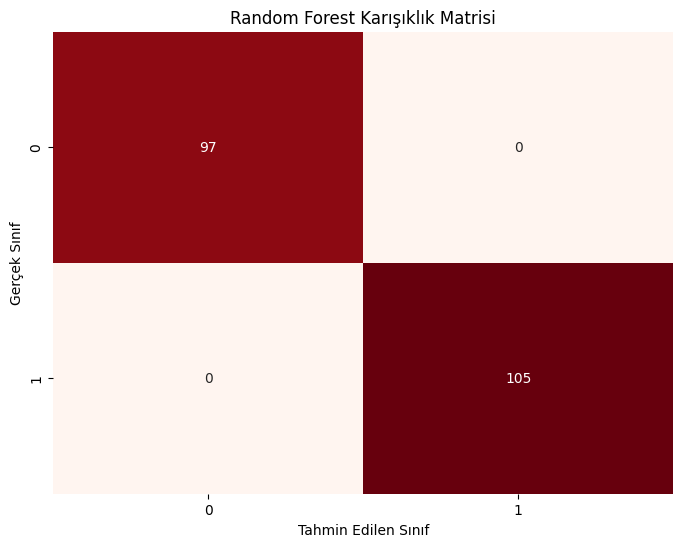

In [ ]:
# Random Forest için karışıklık matrisi görselleştirmesi
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Random Forest Karışıklık Matrisi')
plt.show()


SVM

In [ ]:
# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_selected, y_train)
svm_y_pred = svm_model.predict(X_test_selected)
svm_conf_matrix = confusion_matrix(y_test, svm_y_pred)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"SVM Doğruluk: {svm_accuracy * 100:.2f}%")
print(svm_conf_matrix)

SVM Doğruluk: 100.00%
[[ 97   0]
 [  0 105]]


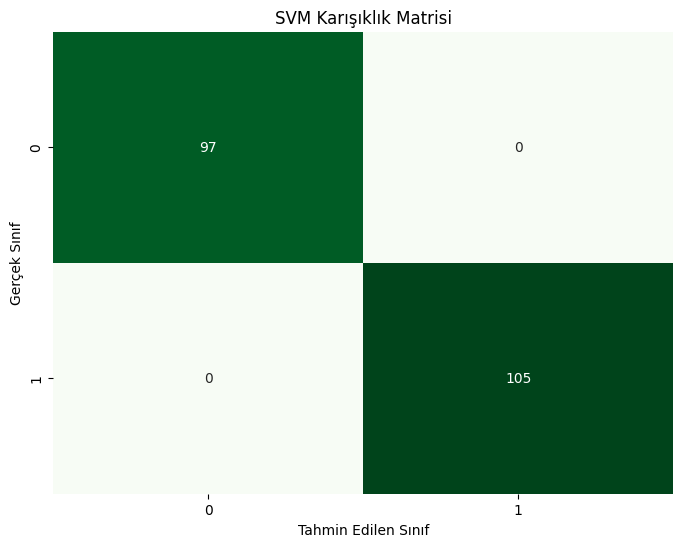

In [ ]:
# SVM için karışıklık matrisi görselleştirmesi
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('SVM Karışıklık Matrisi')
plt.show()